# Exercise 2: Regression

Se realizará una regresion lineal para el dataset `bottle`

In [1]:
using DataFrames, CSV, Plots, GLM, Random, FileIO, Images, Statistics

In [2]:
# Leer el df generado en el ejercicio 1
df_bottle = CSV.read("/mnt/c/Users/omarm/Downloads/bottle/bottle_clean.csv", DataFrame);


Después de leer el dataframe ya limpio del ejercicio 1, se selecciona la columna con la que se trabajará la regresión lineal

In [3]:
first(df_bottle, 3)
# Proporcion para el conjunto de entrenamiento
train_ratio = 0.7
# Columna usada para la regresion
column_name = "R_PRES"

"R_PRES"

Se revuelven los datos y se particionan en los conjuntos para entrenamiento y prueba.

In [4]:
# Crear los conjuntos de test y train con una semilla especifica
df_shuffled = shuffle(MersenneTwister(3915), df_bottle)
n_train = floor(Int, train_ratio*size(df_bottle, 1))
n_test = floor(Int, (1-train_ratio)*size(df_bottle, 1))

println("Entrenamiento: $n_train  Testeo: $n_test")
# Dividir el dataframe
train_data = df_shuffled[1:n_train, :]
test_data = df_shuffled[n_train+1:size(df_shuffled, 1), :]
nothing

Entrenamiento: 544860  Testeo: 233511


Se crea una función para evaluar el modelo resultante, con parámetros como el coeficiente de correlación de Pearson (R^2) o el Root Mean Square Error (RMSE). Además, se guarda la gráfica de los valores predichos versus los valores reales

In [5]:
function metrics(model, test_data, column_predicted, fig_name)
    y_true = test_data[!,column_predicted]
    y_pred = predict(model, test_data)

    RMSE = sqrt(sum((y_true .- y_pred).^2) / length(y_true))
    rsq = r2(model)
    println("RMSE: ", RMSE)
    println("R^2: ", rsq)

    ## Guardar grafica
    plots = scatter(y_true, y_pred, xlabel="Valores reales", ylabel="Valores predecidos", title="Valores reales vs predecidos", color=:red, fmt = :png)
    path = pwd()
    path = path[1:length(path)-3]
    savefig(plots,"$path" * "fig/$fig_name.png")
    img = FileIO.load("$path" * "fig/$fig_name.png")
end

metrics (generic function with 1 method)

Primero ajustamos el modelo con todas las columnas del dataframe, esta regresión multivariable genera predicciones casi perfectas para el valor de la presión, ahora se procederá a quitar variables para determinar cuáles son las más importantes en la predicción.

R_PRES ~ Depthm + T_degC + Salnty + O2ml_L + STheta + R_Depth + R_TEMP + R_POTEMP + R_SALINITY + R_SIGMA + R_SVA + R_DYNHT + R_O2
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

R_PRES ~ 1 + Depthm + T_degC + Salnty + O2ml_L + STheta + R_Depth + R_TEMP + R_POTEMP + R_SALINITY + R_SIGMA + R_SVA + R_DYNHT + R_O2

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error        t  Pr(>|t|)     Lower 95%      Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)    7.10394     2.56202        2.77    0.0056    2.08246      12.1254
Depthm        -0.00477351  0.283917      -0.02    0.9866   -0.561242      0.551695
T_degC       -22.6746      0.760974     -29.80    <1e-99  -24.1661      -21.1831
Salnty        -7.81695   

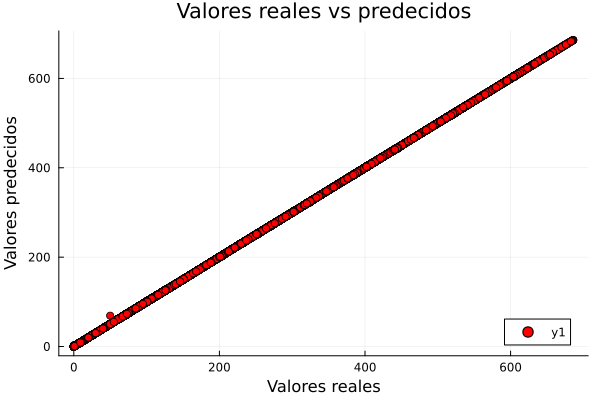

In [6]:
columns_to_fit = Symbol.([name for name in names(train_data) if name != column_name])
fm1 = Term(Symbol(column_name)) ~ sum(Term(v) for v in columns_to_fit)

println(fm1)
# Ajustar el modelo
model1 = lm(fm1, train_data)
println(model1)
metrics(model1, test_data, Symbol(column_name), "figura1")


En el siguiente modelo se redujo todas las variables comparativas a únicamente una `R_Depth`, pero aun así las predicciones resultan sumamente buenas siendo caso perfectas, con un coeficiente de Pearson muy elevado.

R_PRES ~ R_Depth
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

R_PRES ~ 1 + R_Depth

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error          t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.24164  0.000643818    -375.32    <1e-99  -0.242902  -0.240378
R_Depth       1.0071   2.77465e-6   362964.38    <1e-99   1.00709    1.00711
─────────────────────────────────────────────────────────────────────────────
RMSE: 0.32882356277254987
R^2: 0.9999958642572564


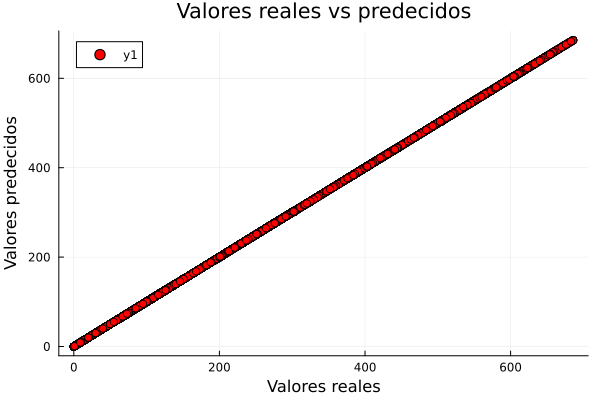

In [7]:
fm2 = @formula(R_PRES ~ R_Depth)
println(fm2)
# Ajustar el modelo
model2 = lm(fm2, train_data)
println(model2)
metrics(model2, test_data, Symbol(column_name), "figura2")

Finalmente, en este tercer modelo se presentan la comparativa con el ajuste con todas las columnas que presentan una menor correlación respecto a la columna de la presión, como se puede observar, a pesar de ser muchas variables no se logra tener una predicción adecuada, teniendo un modelo muy pobre.

R_PRES ~ T_degC + O2ml_L + STheta + R_TEMP + R_POTEMP + R_SIGMA + R_SVA + R_DYNHT + R_O2
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

R_PRES ~ 1 + T_degC + O2ml_L + STheta + R_TEMP + R_POTEMP + R_SIGMA + R_SVA + R_DYNHT + R_O2

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error        t  Pr(>|t|)    Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)  -22967.3      268.15       -85.65    <1e-99  -23492.9     -22441.7
T_degC         4038.27      86.6811      46.59    <1e-99    3868.38      4208.16
O2ml_L           51.6907    47.95         1.08    0.2810     -42.2898     145.671
STheta          836.611     18.3143      45.68    <1e-99     800.716      872.506
R_TEMP         -246.159     85.69

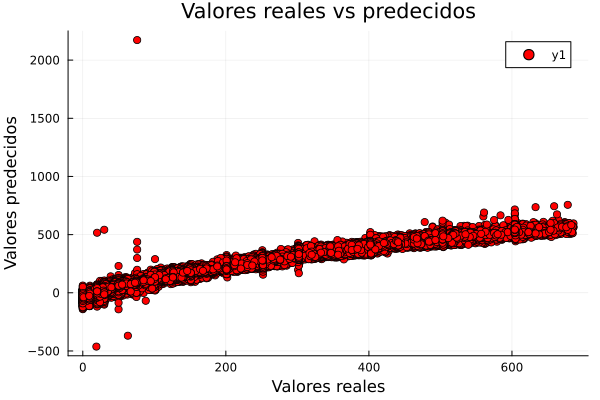

In [8]:
fm3 = @formula(R_PRES ~ T_degC + O2ml_L + STheta + R_TEMP + R_POTEMP + R_SIGMA + R_SVA + R_DYNHT + R_O2)
model3 = lm(fm3, train_data)
println(fm3)
# Ajustar el modelo
println(model3)
metrics(model3, test_data, Symbol(column_name), "figura3")

Como conclusión, para el caso de la presión se tienen predicciones sumamente buenas al ajustar el modelo con variables relacionadas a la profundidad (depth), esto es lógico debido a que la relación presión-profundidad es lineal.